In [8]:
!pip install opencv-python

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [10]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg -O messi5.jpg
import os

if not os.path.exists('messi5.jpg'):
    print("Download failed. Use another image or upload manually.")
else:
    print("messi5.jpg downloaded.")

messi5.jpg downloaded.


Original shape: (342, 548, 3)
Level 1 shape: (171, 274, 3)
Level 2 shape: (86, 137, 3)


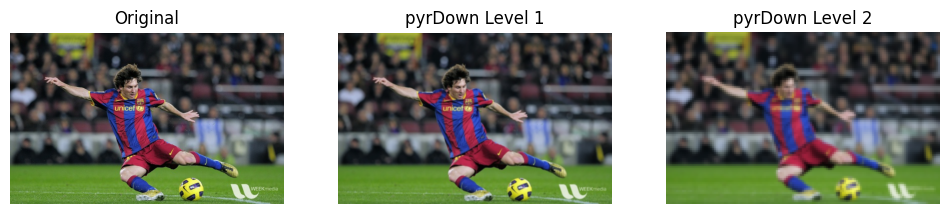

In [11]:
img = cv.imread('messi5.jpg')
if img is None:
  raise FileNotFoundError('Image not found.')

level1 = cv.pyrDown(img)
level2 = cv.pyrDown(level1)

level1_up = cv.pyrUp(level1)
level2_up = cv.pyrUp(level2)

print('Original shape:', img.shape)
print('Level 1 shape:', level1.shape)
print('Level 2 shape:', level2.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2), plt.imshow(cv.cvtColor(level1, cv.COLOR_BGR2RGB))
plt.title('pyrDown Level 1'); plt.axis('off')
plt.subplot(1,3,3), plt.imshow(cv.cvtColor(level2, cv.COLOR_BGR2RGB))
plt.title('pyrDown Level 2'); plt.axis('off')
plt.show()

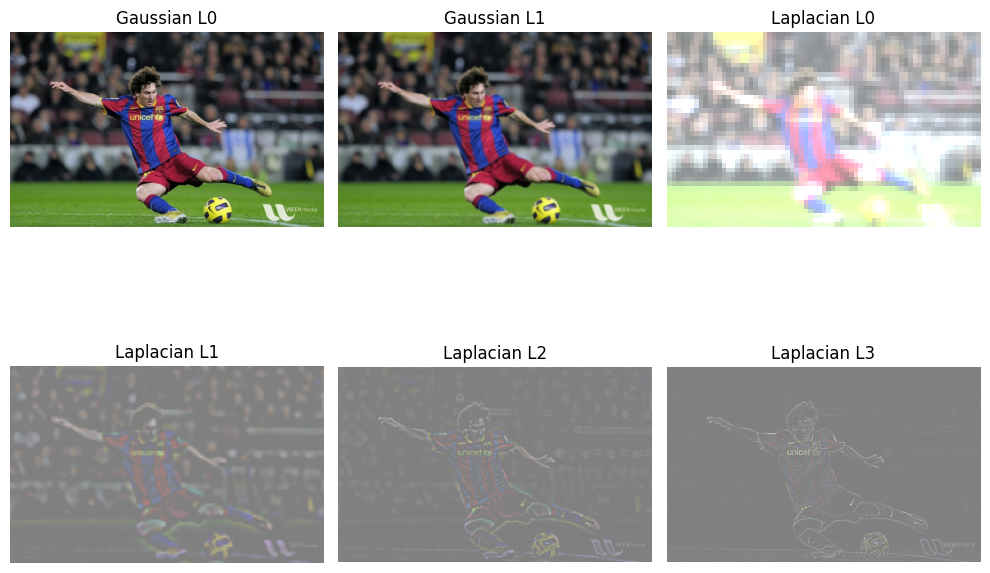

In [12]:
def build_gaussian_pyramid(img, levels=3):
    # levels=3 means 0,1,2
    g_pyr = [img]
    tmp = img
    for i in range(levels):
        tmp = cv.pyrDown(tmp)
        g_pyr.append(tmp)
    return g_pyr

def build_laplacian_pyramid(g_pyr):
    # g_pyr[-1] is the smallest Gaussian level
    l_pyr = [g_pyr[-1]]  # last level is same in Laplacian
    for i in range(len(g_pyr) - 1, 0, -1):
        # expand g_pyr[i] and subtract from g_pyr[i-1]
        up = cv.pyrUp(g_pyr[i])
        # make sure shapes match
        up = up[:g_pyr[i-1].shape[0], :g_pyr[i-1].shape[1]]
        lap = cv.subtract(g_pyr[i-1], up)
        l_pyr.append(lap)
    return l_pyr

g_levels = 3
g_pyr = build_gaussian_pyramid(img, g_levels)
l_pyr = build_laplacian_pyramid(g_pyr)

# 시각화
plt.figure(figsize=(10,8))
for i, gp in enumerate(g_pyr):
    plt.subplot(2,g_levels, i+1)
    plt.imshow(cv.cvtColor(gp, cv.COLOR_BGR2RGB))
    plt.title(f'Gaussian L{i}')
    plt.axis('off')

for j, lp in enumerate(l_pyr):
    plt.subplot(2, g_levels, g_levels + j)
    # Laplacian can have negative, so shift to display
    # or just convert to absolute
    show = cv.convertScaleAbs(lp, alpha=1.0, beta=128)
    plt.imshow(cv.cvtColor(show, cv.COLOR_BGR2RGB))
    plt.title(f'Laplacian L{j}')  # Changed to reflect level j in l_pyr
    plt.axis('off')

plt.tight_layout()
plt.show()

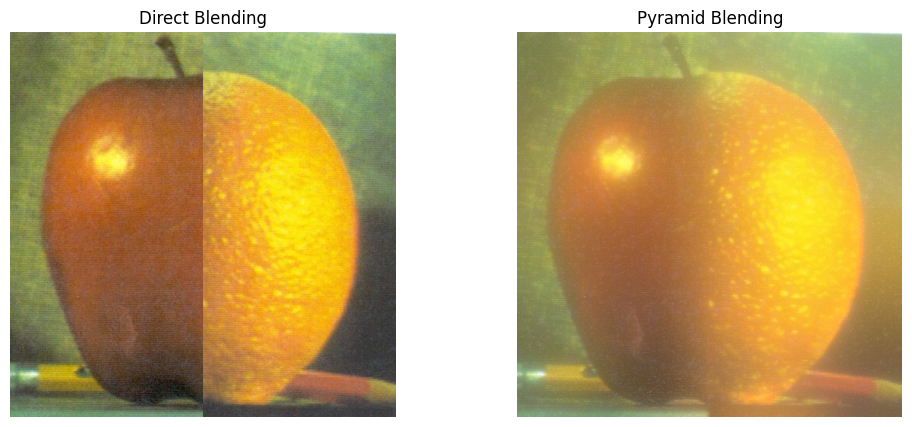

In [13]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/apple.jpg -O apple.jpg
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/orange.jpg -O orange.jpg

A = cv.imread('apple.jpg')
B = cv.imread('orange.jpg')

if A is None or B is None:
    print("apple.jpg / orange.jpg not found.")
else:
    # For blending, let's ensure same size
    # (Or resize one to match the other)
    rows = min(A.shape[0], B.shape[0])
    cols = min(A.shape[1], B.shape[1])
    A = A[:rows, :cols]
    B = B[:rows, :cols]

    # Direct half-split
    real = np.hstack((A[:, :cols//2], B[:, cols//2:]))

    # Build Gaussian pyramids
    G_A = [A]
    G_B = [B]
    levels = 6
    for i in range(levels):
        G_A.append(cv.pyrDown(G_A[-1]))
        G_B.append(cv.pyrDown(G_B[-1]))

    # Build Laplacian pyramids
    L_A = [G_A[-1]]
    L_B = [G_B[-1]]
    for i in range(levels-1, -1, -1):
        GA_up = cv.pyrUp(G_A[i+1])
        GA_up = GA_up[:G_A[i].shape[0], :G_A[i].shape[1]]
        LA = cv.subtract(G_A[i], GA_up)
        L_A.append(LA)

        GB_up = cv.pyrUp(G_B[i+1])
        GB_up = GB_up[:G_B[i].shape[0], :G_B[i].shape[1]]
        LB = cv.subtract(G_B[i], GB_up)
        L_B.append(LB)

    # Blend each level's laplacian
    LS = []
    for la, lb in zip(L_A, L_B):
        la_cols = la.shape[1]
        ls = np.hstack((la[:, :la_cols//2], lb[:, la_cols//2:]))
        LS.append(ls)

    # Reconstruct
    blend = LS[0]
    for i in range(1, len(LS)):
        blend = cv.pyrUp(blend)
        blend = blend[:LS[i].shape[0], :LS[i].shape[1]]
        blend = cv.add(blend, LS[i])

    # Save or show results
    cv.imwrite('Pyramid_blending.jpg', blend)
    cv.imwrite('Direct_blending.jpg', real)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(real, cv.COLOR_BGR2RGB))
    plt.title('Direct Blending')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(blend, cv.COLOR_BGR2RGB))
    plt.title('Pyramid Blending')
    plt.axis('off')
    plt.show()